In [1]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))   

Author: Andrew Tarzia

Date Created: 26 Mar 2018

License:

# Notebook for calculating the relative zinc ion affinity for different models of carbohydrate chains

TODO:


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# replace matlab BVP solver with scipy
from scipy.integrate import solve_bvp
import scipy.special as sc
%run ./expressions.py

# Notes:
## pK values:
- pK values:

## Setup

In [3]:
# constants
T = 298 # [K]
KB = 1.38064852E-23 # boltzmann constant [J/K]
NA = 6.022140857E23 # avogadros number [mol-1]
e = 1.60217662E-19 # elementary charge [C]
E_r = 78.46 # relative permittivity [unit less] -- water!
E_0 = 8.854187817e-12 # Vacuum permittivity [F/m = C^2/(J.m)]
M_TO_NM = 1.0e9 # conversion from m to nm
M3_TO_L = 1.0e3 # conversion from m^3 to L
R0 = 1.0e-12 # a small reduced distance to avoid singularity at r=0
PI = np.pi

print("============= Constants =============")
print("temperature =", T, "K")
print("kB =", KB, "J/K")
print("kBT =", KB*T*NA/1000, "kJ/mol")
print("Avogadros Number =", NA, "mol^-1")
print("elementary charge =", e, "C")
print("relative permittivity =", E_r)
print("vacuum permittivity =", E_0, "C V^-1 m^-1")
print("=====================================")

## variables ##
# salt concs (1 - Zn2+)
salt1_conc = 0.04  # mol/L 
salt2_conc = 0.08  # mol/L 
# bulk salt conc (total)
salt_conc = salt1_conc + salt2_conc  # mol/L 
# ion valencies
Z1 = 2  # zinc 2+
Z2 = -1  # co-ion
# monomer length (length of Glucose unit)
Lc = 5 # angstrom
# number of monomers in carbohydrate chain
# or degree of polymerisation DP
DP = 20
# cylinder radius
# assume it is half the amount for double stranded DNA
a = 5  # angstrom
# set pH
PH = 11
# get cylinder surface area
surf_area = 2 * np.pi * a * DP*Lc + 2 * np.pi * (a ** 2)

============= Constants =============
temperature = 298 K
kB = 1.38064852e-23 J/K
kBT = 2.477709038711677 kJ/mol
Avogadros Number = 6.022140857e+23 mol^-1
elementary charge = 1.60217662e-19 C
relative permittivity = 78.46
vacuum permittivity = 8.854187817e-12 C V^-1 m^-1


## Charge of cylinders using Henderson Hasselbach Equation
### Assumes functionaloties are the only charge centres.

In [4]:
func_colors = {"COO": 'firebrick', "NH2": 'royalblue'}

# set functionalisation density as degree of substitution:
# DS = avg number of substituted OH for CH3COONa per glucose (max at 3, for 3 OH)
# vary the degree of substitution
DS = np.linspace(0.01, 1.0, 20)
func_count = DS * DP
# set the average distance between charges on cylinder
# from DS
# in angstrom
b_ = Lc / DS

# set plot colours
colour = cm.coolwarm(np.linspace(0.5, 1, len(DS)))

# set charge and pka of functionalisations
func_charges = {"COO": -1, "NH2": +1}#, "none": 0}
func_pkas = {"none": 0, "COO": 4, "NH2": 12}

# calculate cylinder charge of each functionalisation based on pH 
func_total_charges = {}
for func in func_charges.keys():
    if func == 'none':
        partial_charge = 0
    else:
        pka = func_pkas[func]
        charge = func_charges[func]
        partial_charge = calculate_func_charge(charge, PH, pka)
    func_total_charges[func] = func_count * partial_charge


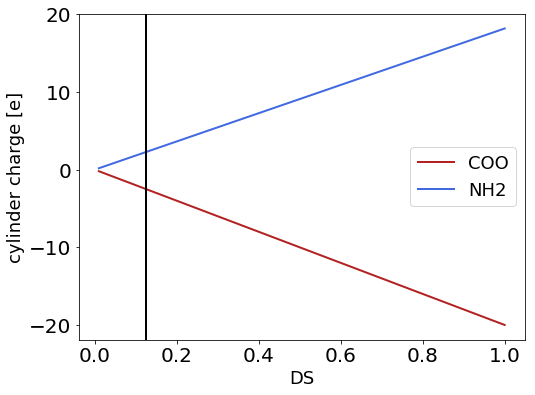

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
for func in func_charges.keys():
    ax.plot(DS, func_total_charges[func], label=func, c=func_colors[func], lw=2)

ax.set_xlabel("DS", fontsize=18)
ax.set_ylabel("cylinder charge [e]", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=18)

ax.axvline(x=0.125, c='k', lw=2)

plt.show()

#  04/05/18
## Numerical solution - DMH code into Python - change BCs.

In [6]:
def fun(rr,y):
    """Poisson-Boltzmann equation in cylindrical coords.
    
    Poisson-Boltzmann equation in cylindrical coordinates in reduced units 
    expressed as 2 coupled 1st-order ODEs for use in bvp function:
      y(1) = psir = z*e/(k*T)*psi 
              => 1/r*d/dr*(r*dpsir/dr) = kappa^2*sinh(psir)
      y(2) = rr*dpsir/drr  (rr = r/radius)
      y(1)' = y(2)/rr 
      y(2)' = rr*kappar^2*sinh(y(1))  (kappar = kappa*radius)
      
    Modifed to fit the 2-1 salt case:
    (From Tracy paper - using their definitions)
    y(r) = e/(k*T)*psi(r)
        
    y(1) = (1/3)(exp(2y) - exp(-y))
    y(2) = (1/3)(2exp(2y) + exp(-y))
    
    y(1)' = y(2)
    y(2)' = (1/3)(exp(2y) - exp(-y))
    
    """
    dydr = np.vstack([y[1]/rr, 
                      (rr/3) * (np.exp(2*y[0]) - np.exp(-y[0]))])
    #print(dydr)
    return dydr

# -----------------------------------------------------------------------

def bc(ya, yb):
    """BCs for Poisson-Boltzmann equation in cylindrical coords.
    Boundary conditions for Poisson-Boltzmann equation in cylindrical
    coordinates in reduced units:
      y(1) = psir = z*e/(k*T)*psi
      y(2) = rr*dpsir/drr  (rr = r/radius)
      y(2) = 0 at r=0 
      y(2) = z*e*sig*radius/(eps0*eps*k*T) = sigr
      
    redefined:
        if:
          y(1) = psir = z*e/(k*T)*psi
          y(2) = rr*dpsir/drr  (rr = r/radius)
        BCs:
          y(2) = z*e*sig*radius/(eps0*eps*k*T) = sigr at r=radius
          y(2) = 0 at r=R
              
    notes:
        ya[0] implies the function y at first boundary a
        ya[1] implies the function y' at first boundary a
        yb[0] implies the function y at second boundary b
        yb[1] implies the function y' at second boundary b
                      
    """
    global sigr
    res = [ya[1] + sigr,
           yb[0]]
    return res

# -----------------------------------------------------------------------

def pb_cylinder_init( rr ,sigr, kappar ):
    """Initial guess for solution to PB eqn in cylindr. coords
    Initial guess for solution to Poisson-Boltzmann equation in 
    cylindrical coordinates in reduced units:
      y(1) = psir = z*e/(k*T)*psi
      y(2) = rr*dpsir/drr
      kappar = kappa*radius
      rr = r/radius
    Set solution to analytical solution for linearized PB in cylindrical
    coords with an empirical correction to account for 
    errors for radii close to the Deybe length:
    psi = sig/(eps0*eps)/kappa*I0(kappa*r)/I1(kappa*radius)
    => y(1) = psir = sigr/kappar*I0(kappar*r)/I1(kappar)
       y(2) = rr*dpsir/drr = sigr*rr*I1(kappa*r)/I1(kappar)
    
    Modified:
        if:
            y(1) = psir = z*e/(k*T)*psi
            y(2) = rr*dpsir/drr
        set to analytical solution:
            y(1) = psir = sigr/kappar*I0(r)/I1(kappar)
            y(2) = rr*dpsir/drr = sigr*rr*I1(r)/I1(kappar)
    
    """
    yinit = np.vstack(((sigr/kappar)*(sc.kn(0, rr))/sc.kn(1, kappar),
                       sigr*rr*sc.kn(1, rr)/sc.kn(1, kappar)))

    return yinit

In [7]:
# radial positions from surface of cylinder (angstrom)
r_in = np.linspace(a, 150, 1000)
r_out = np.linspace(a, 150, 1000)

In [8]:
# calculate bjerrum length
# in angstrom
print("-------------------------------")
lb = calculate_bjerrum_length(Z1)
print('lb =', lb, 'angstrom')
lb_m = lb * (10 ** -10)
print('lb =', lb_m, 'm')
print("-------------------------------")
# calculate ionic strength
I = 0.5 * ((salt1_conc * Z1 * Z1) + (salt2_conc * Z2 * Z2))  # mol/L
print('I =', I, 'mol/L')
# in molec per m3
I_m = NA * I * 1000  # molecules / m3
print('I =', I_m, 'm^-3')
print("-------------------------------")
# calculate kappasq
# in angstrom^-2
kappasq = calculate_kappasq(lb_m, I_m)
print('kappa^2 =', kappasq, 'm^-2')
print('kappa =', np.sqrt(kappasq * (10 ** -20)), 'angstrom^-1')
print('debye length =', 1/np.sqrt(kappasq * (10 ** -20)), 'angstrom')
print("-------------------------------")

-------------------------------
lb = 7.146998626764947 angstrom
lb = 7.146998626764947e-10 m
-------------------------------
I = 0.12 mol/L
I = 7.2265690284e+25 m^-3
-------------------------------
kappa^2 = 1.2980628290602427e+18 m^-2
kappa = 0.11393256027406048 angstrom^-1
debye length = 8.777122164151649 angstrom
-------------------------------


In [9]:
# reduced radial distance [unitless]
# in units of debye length
r_r_in = np.sqrt(kappasq * (10 ** -20)) * r_in
r_r_out = np.sqrt(kappasq * (10 ** -20)) * r_out

In [10]:
r_out[r_out < 5.74]

array([5.        , 5.14514515, 5.29029029, 5.43543544, 5.58058058,
       5.72572573])

In [11]:
_dist_slice = [1, 5]

print((r / np.sqrt(kappasq * (10 ** -20)))[r < (r[0] + np.sqrt(kappasq * (10 ** -20)) * 0.74)])
print((r / np.sqrt(kappasq * (10 ** -20)))[1:9])
print(r[r < 0.74])

Counter(r < (r[0] + np.sqrt(kappasq * (10 ** -20)) * 0.74))

In [12]:
plot_summary = True
plot_analytical = True

=================== COO ==================
[[-2.79992066e-02 -2.72238709e-02 -2.64774479e-02 ... -4.03172350e-10
  -3.96370578e-10 -3.89683734e-10]
 [-1.55096857e-02 -1.53593829e-02 -1.52090391e-02 ... -4.03072034e-09
  -3.96645494e-09 -3.90321250e-09]]
(2, 1000)
[[-1.73889810e-01 -1.69074566e-01 -1.64438887e-01 ... -2.50391249e-09
  -2.46166990e-09 -2.42014108e-09]
 [-9.63233110e-02 -9.53898519e-02 -9.44561373e-02 ... -2.50328948e-08
  -2.46337728e-08 -2.42410039e-08]]
(2, 1000)
negatively charged cylinder
=================== NH2 ==================
[[2.54538268e-02 2.47489760e-02 2.40704096e-02 ... 3.66520355e-10
  3.60336925e-10 3.54257975e-10]
 [1.40997157e-02 1.39630768e-02 1.38264005e-02 ... 3.66429159e-09
  3.60586849e-09 3.54837535e-09]]
(2, 1000)
[[1.58081661e-01 1.53704167e-01 1.49489912e-01 ... 2.27628431e-09
  2.23788196e-09 2.20012848e-09]
 [8.75666551e-02 8.67180558e-02 8.58692243e-02 ... 2.27571793e-08
  2.23943411e-08 2.20372785e-08]]
(2, 1000)
positively charged cylinde

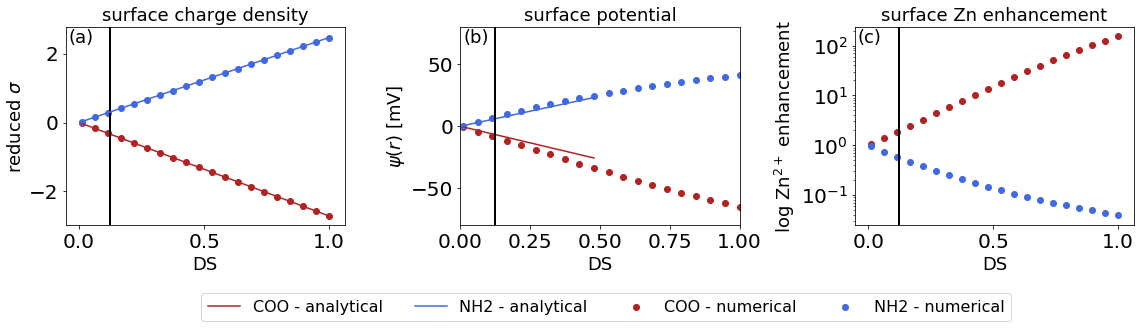

In [14]:
# thermal voltage [V]
Vt = KB*T/(e)
radius = a * (10 ** -10)  # m

# iterate over funcationalities
if plot_summary:
    fig = plt.figure(figsize=(16, 4))
    ax1 = plt.subplot(131)
    ax1.tick_params(axis='both', which='major', labelsize=20)
    # label
    ax1.text(0.01, 0.9, '(a)',
             verticalalignment='bottom', horizontalalignment='left',
             transform=ax1.transAxes,
             fontsize=18)
    ax2 = plt.subplot(132)
    ax2.tick_params(axis='both', which='major', labelsize=20)
    ax2.text(0.01, 0.9, '(b)',
             verticalalignment='bottom', horizontalalignment='left',
             transform=ax2.transAxes,
             fontsize=18)
    ax3 = plt.subplot(133)
    ax3.tick_params(axis='both', which='major', labelsize=20)
    ax3.text(0.01, 0.9, '(c)',
             verticalalignment='bottom', horizontalalignment='left',
             transform=ax3.transAxes,
             fontsize=18)


func_surface_concentration = {}
for func in func_charges.keys():
    print("===================", func, "==================")
    sigma = calculate_sigma_of_cylinder(func_total_charges[func], DP*Lc, a)
    if plot_summary:
        ax1.scatter(DS, sigma*radius/(E_0*E_r*Vt), c=func_colors[func])
        ax1.set_title('surface charge density', fontsize=18)
        ax1.set_xlabel("DS", fontsize=18)
        ax1.set_ylabel('reduced $\sigma$', fontsize=18)
        ax1.axvline(x=0.125, c='k', lw=2)
    
    # collect data for each DS
    psi_= []
    
    for i, ds in enumerate(DS):
        # calculate surface charge density
        sigma = calculate_sigma_of_cylinder(func_total_charges[func][i], DP*Lc, a)
        # reduced surface charge - unitless
        sigr = sigma*radius/(E_0*E_r*Vt)
        # reduced Debye screening parameter
        kappar = np.sqrt(kappasq * (10 ** -20)) * a
        # square of reduced Debye screening parameter
        kappasqr = kappar*kappar

        # initial solution guess
        #print(sigr,kappar)
        if i == 0 or i == 1:
            solInit = pb_cylinder_init(r_r_in, sigr, kappar)
            y = solInit
        else:
            # use previous solution as input to current run
            y = solution.y

        # fun = RHS of system of ODEs
        # bc = boundary conditions
        # x = initial mesh
        # y = initial guess
        #sol = solve_bvp(pb_cylinder_ode(r,y,kappasqr), pb_cylinder_bc(r,y,sigr), r, y)#,p=[kappasqr,sigr])
        solution = solve_bvp(fun, bc, r_r_in, y)

        # reduced radial coord. (for output)        
        # reduced electrostatic potential
        # output the values of sol for all r
        psir = solution.sol(r_r_out)[0]
        poly = solution.sol
        dpsir = poly.derivative()(r_r_out)[0]

        # sol.stats
        # electrostatic potential [mV]
        psi = psir * Vt * 1000 
        psi_.append(psi)
        if plot_summary is False:
            plt.title(ds)
            plt.plot(r_r_out, psi)
            plt.show()

    if plot_analytical:
        sigma = calculate_sigma_of_cylinder(func_total_charges[func], DP*Lc, a)
        # Equation 1.4
        # line charge density lambda
        lamb = calculate_lambda(a, sigma)
        if lamb[-1] > 0:
            print("positively charged cylinder")
            # Equation 1.5
            zeta_ = calculate_manning_parameter(lamb, lb, Z1)
            ax1.plot(DS, zeta_*2, c=func_colors[func])
        elif lamb[-1] <= 0:
            print("negatively charged cylinder")
            # Equation 1.5
            zeta_ = calculate_manning_parameter(lamb, lb, Z1)
            ax1.plot(DS, -zeta_*2, c=func_colors[func])

        # calculate reduced potential using the DH solution (https://arxiv.org/abs/cond-mat/9701067 E2.1)
        # - as a function of b (distance between charges) - multiple values used
        ys = calculate_y(zeta_, r_r_in, lamb)
        # calculate SI potential (psi(r))
        psi_a = []
        for i in ys:
            psi = i * KB * T / (e) #  * Z1)# Volts
            psi_a.append(psi * 1000) # mV
        
        ax2.plot(DS[DS <= 0.5], np.asarray([np.average(i[_dist_slice[0]:_dist_slice[1]]) for i in psi_a])[DS <= 0.5],
                 c=func_colors[func])
    if plot_summary:
        ax2.scatter(DS, [np.average(i[_dist_slice[0]:_dist_slice[1]]) for i in psi_], c=func_colors[func])
        ax2.set_title(r'surface potential', fontsize=18)
        #ax.set_xlabel("distance from cylinder surface [$\mathrm{\AA}$]", fontsize=18)
        ax2.set_ylabel("$\psi(r)$ [mV]", fontsize=18)
        ax2.set_xlabel("DS", fontsize=18)
        ax2.axvline(x=0.125, c='k', lw=2)
        ax2.set_xlim(0, 1)
        ax2.set_ylim(-80, 80)
    # calculate avg concentration of zinc ions at the surface from psi(r)
    # within 1 Zinc radius 0.74 Ang from surface!
    # using boltzmann equation
    # c+/- = c+/-(bulk) * exp[-/+Z+/i*psi]
    zinc_conc = []
    zinc_counter_conc = []
    for i in psi_:   # SI
    #for i in ys:   # reduced
        surf_pot = np.average(i[_dist_slice[0]:_dist_slice[1]]) / 1000   # SI # in V
        z_c = calculate_conc(surf_pot, salt1_conc, Z1)   # SI
        z_counter_c = calculate_conc(surf_pot, salt2_conc, Z2)   # SI
        #surf_pot = np.average(i[1:5])   # reduced
        #z_c = calculate_reduced_conc(surf_pot, salt1_conc, Z1)   # reduced
        #z_counter_c = calculate_reduced_conc(surf_pot, salt2_conc, Z2)   # reduced
        zinc_conc.append(z_c)
        zinc_counter_conc.append(z_counter_c)
    # enhancement
    if plot_summary:
        ax3.scatter(DS, [i/salt1_conc for i in zinc_conc], c=func_colors[func])
        ax3.set_title('surface Zn enhancement', fontsize=18)
        ax3.set_xlabel("DS", fontsize=18)
        ax3.set_ylabel("log Zn$^{2+}$ enhancement", fontsize=18)
        ax3.set_yscale("log", nonposy='clip')
        ax3.axvline(x=0.125, c='k', lw=2)
        #ax4.legend(fontsize=18)
    print("==========================================")
    
# legend
for func in func_charges.keys():
    ax2.scatter(-1000, -1000, c=func_colors[func], label=func+" - numerical")
    ax2.plot([-1000, -999], [-1000, -999], c=func_colors[func], label=func+" - analytical")

ax2.legend(fancybox=True, ncol=4, bbox_to_anchor=(2, -0.3),
           fontsize=16)
fig.tight_layout()
fig.savefig('../../documents/images/cylinder_model_numerical.pdf', dpi=720, bbox_inches='tight')

In [ ]:
function [ r, psi, dpsi ] = epot_pb_cylinder( nPointsIn, nPointsOut, ...
                        temp, epsilon, sig, valence, cbulk, radius,  ...
                        plotFlag, outFlag)
%EPOT_PB_CYLINDER Compute electrical potential of electrolyte in cylinder
%   Compute electrostatic potential of a z:z electrolyte in cylindrical 
%   coordinates from Poisson-Boltmann equation
%
%   Variables
%   r               radial coordinate [m]
%   psi             electrostatic potential [V]
%   dpsi            derivative of electrostatic potential wrt r [V/m]
%  
%   Parameters:
%   nPointsIn       no. of r points in initial mesh for BVP solver
%   nPointsOut      no. of r points at which to output potential
%   temp            temperature [K]
%   epsilon         dielectric constant [unitless]
%   sig             surface charge density [C/m^2]
%   valence         ion valence [unitless]
%   cbulk           bulk electrolyte concentration [mol/L]
%   radius          pore radius [m]
%   plotFlag        flag to plot potential (1=yes,0=no)
%   outFlag         flag to output potential to file (1=yes,0=no)

global ECHARGE       % Elementary charge [C]
global EPS0          % Vacuum permittivity [F/m = C^2/(J.m)]
global KB            % Boltzmann constant [J/K]
global NA            % Avogadro constant
global M_TO_NM       % conversion from m to nm
global M3_TO_L       % conversion from m^3 to L
global R0            % a small reduced distance to avoid singularity at r=0

ECHARGE = 1.6021766208e-19;   
EPS0 = 8.854187817e-12;       
KB = 1.38064852e-23;
NA = 6.022140857e23;
M_TO_NM = 1.0e9;
M3_TO_L = 1.0e3;
R0 = 1.0e-12;

cbulk_mol = cbulk*NA*M3_TO_L; % convert conc. from mol/L to molecule/m^3
Vt = KB*temp/(valence*ECHARGE);     % thermal voltage [V]
kappasq = 2.0.*valence.*ECHARGE.*cbulk_mol/(EPS0.*epsilon.*Vt);  
                         % square of Debye screening parameter [1/m^2]
kappa = sqrt(kappasq);   % Debye screening parameter [1/m]
lambdaD = 1.0./kappa;    % Debye screening length [m]
sigr = sig.*radius./(EPS0.*epsilon.*Vt); % reduced surface charge
kappar = kappa.*radius;    % reduced Debye screening parameter
kappasqr = kappar.*kappar; % square of reduced Debye screening parameter
                                             
r = linspace(R0,50.0,nPointsIn);  % reduced radial coord. (for initial mesh) 

solInit = bvpinit(r,@(r1) pb_cylinder_init(r1,sigr,kappar));
sol = bvp5c(@(r1,y) pb_cylinder_ode(r1,y,kappasqr), ...
			@(ya,yb) pb_cylinder_bc(ya,yb,sigr),solInit);

r = linspace(R0,50.0,nPointsOut);  % reduced radial coord. (for output)        
psir = deval(sol,r,1);   % reduced electrostatic potential
dpsir = deval(sol,r,2)./r;  % derivative of reduced potential

%sol.stats

psi = Vt.*psir;       % electrostatic potential [V]
dpsi = Vt./radius.*dpsir;    % derivative of electrostatic potential [V/m]
r = radius.*r;       % radial coord [m]

% plot potential
if plotFlag == 1
    
    psiInit = Vt.*sigr./kappar.* ...
            (besseli(0,kappa.*r) - 1.0)./besseli(1,kappar) + ...
            0.2.*Vt.*sigr./(kappar).^1.3;

    figure;
    plot(r*M_TO_NM,psi,r*M_TO_NM,psiInit);
    xlabel('r [nm]');
    ylabel('psi [V]');
    legend('psi','psi_{init}','Location','North');

    figure;
    plot(r./radius,psir,r./radius,psiInit./Vt);
    xlabel('r/a');
    ylabel('z*e*psi/kT');
    legend('z*e*psi/kT','z*e*psi_{init}/kT','Location','North');
end

% output various parameters to screen and potential and gradient to file
if outFlag == 1
    fprintf('Thermal voltage [V] = %-15.6e\n', Vt);
    fprintf('Deby screening parameter [1/m] = %-15.6e\n', kappa);
    fprintf('Deby screening length [m] = %-15.6e\n', lambdaD);
    fout = fopen('epot.dat','w');
    fprintf(fout,'%-15s %-15s %-15s\n', ...
                                '# r (m)', 'psi (V)', 'dpsi/dr (V/m)');
    for j = 1:nPointsOut
        fprintf(fout,'%-15.6e %-15.6e %-15.6e\n', r(j), psi(j), dpsi(j));
    end
end

end

% -----------------------------------------------------------------------
function dydr = pb_cylinder_ode( rr, y, kappasqr )
% PB_CYLINDER_ODE Poisson-Boltzmann equation in cylindrical coords 
%    Poisson-Boltzmann equation in cylindrical coordinates in reduced units 
%    expressed as 2 coupled 1st-order ODEs for use in bvp function:
%      y(1) = psir = z*e/(k*T)*psi 
%              => 1/r*d/dr*(r*dpsir/dr) = kappa^2*sinh(psir)
%      y(2) = rr*dpsir/drr  (rr = r/radius)
%      y(1)' = y(2)/rr 
%      y(2)' = rr*kappar^2*sinh(y(1))  (kappar = kappa*radius)

dydr = [y(2)./rr      
	    rr.*kappasqr.*sinh(y(1))];

end

% -----------------------------------------------------------------------

function res = pb_cylinder_bc( ya, yb, sigr )
% PB_CYLINDER_BC BCs for Poisson-Boltzmann equation in cylindrical coords
%    Boundary conditions for Poisson-Boltzmann equation in cylindrical
%    coordinates in reduced units:
%      y(1) = psir = z*e/(k*T)*psi
%      y(2) = rr*dpsir/drr  (rr = r/radius)
%      y(2) = 0 at r=0
%      y(2) = z*e*sig*radius/(eps0*eps*k*T) = sigr

res = [ya(2) 
	   yb(2) - sigr];
end

% -----------------------------------------------------------------------

function yinit = pb_cylinder_init( rr ,sigr, kappar )
% PB_CYLINDER_INIT Initial guess for solution to PB eqn in cylindr. coords
%    Initial guess for solution to Poisson-Boltzmann equation in 
%    cylindrical coordinates in reduced units:
%      y(1) = psir = z*e/(k*T)*psi
%      y(2) = rr*dpsir/drr
%      kappar = kappa*radius
%      rr = r/radius
%    Set solution to analytical solution for linearized PB in cylindrical
%    coords with an empirical correction to account for 
%    errors for radii close to the Deybe length:
%    psi = sig/(eps0*eps)/kappa*I0(kappa*r)/I1(kappa*radius)
%    => y(1) = psir = sigr/kappar*I0(kappar*r)/I1(kappar)
%       y(2) = rr*dpsir/drr = sigr*rr*I1(kappa*r)/I1(kappar)

yinit = [sigr./kappar.*(besseli(0,kappar.*rr) - 1.0)./besseli(1,kappar) + 0.2.*sigr./kappar.^1.3
	      sigr.*rr.*besseli(1,kappar.*rr)./besseli(1,kappar)];
end

In [8]:
# calculate bjerrum length
# in angstrom
print("-------------------------------")
lb = calculate_bjerrum_length(Z1)
print('lb =', lb, 'angstrom')
lb_m = lb * (10 ** -10)
print('lb =', lb_m, 'm')
print("-------------------------------")
# calculate ionic strength
I = 0.5 * ((salt1_conc * Z1 * Z1) + (salt2_conc * Z2 * Z2))  # mol/L
print('I =', I, 'mol/L')
# in molec per m3
I_m = NA * I * 1000  # molecules / m3
print('I =', I_m, 'm^-3')
print("-------------------------------")
# calculate kappasq
# in angstrom^-2
kappasq = calculate_kappasq(lb_m, I_m)
print('kappa^2 =', kappasq, 'm^-2')
print('kappa =', np.sqrt(kappasq * (10 ** -20)), 'angstrom^-1')
print('debye length =', 1/np.sqrt(kappasq * (10 ** -20)), 'angstrom')
print("-------------------------------")
# reduced coordinates (unitless)
kr_ = np.sqrt(kappasq * (10 ** -20)) * r_

-------------------------------
lb = 28.587994507059786 angstrom
lb = 2.8587994507059787e-09 m
-------------------------------
I = 0.12 mol/L
I = 7.2265690284e+25 m^-3
-------------------------------
kappa^2 = 5.192251316240971e+18 m^-2
kappa = 0.22786512054812097 angstrom^-1
debye length = 4.3885610820758245 angstrom
-------------------------------


=================== COO ==================
negatively charged cylinder
=================== NH2 ==================
positively charged cylinder


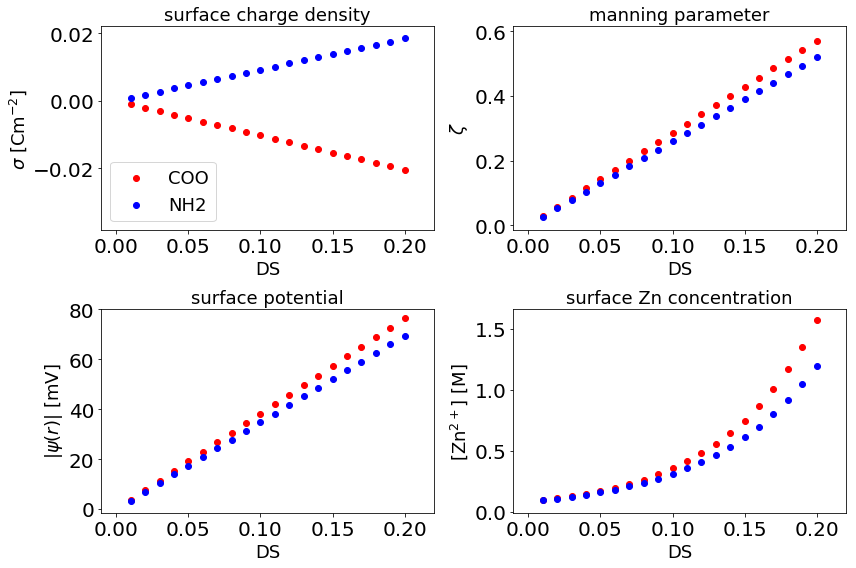

In [9]:
# iterate over funcationalities
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot(221)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2 = plt.subplot(222)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax3 = plt.subplot(223)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax4 = plt.subplot(224)
ax4.tick_params(axis='both', which='major', labelsize=20)

func_surface_concentration = {}
for func in func_charges.keys():
    print("==========================================")
    print("===================", func, "==================")
    # calculate surface charge density
    sigma = calculate_sigma_of_cylinder(func_total_charges[func], N*Lc, a)
    ax1.scatter(DS, sigma, c=func_colors[func], label=func)
    ax1.set_title('surface charge density', fontsize=18)
    ax1.set_xlabel("DS", fontsize=18)
    ax1.set_ylabel('$\sigma$ [Cm$^{-2}$]', fontsize=18)
    ax1.legend(fontsize=18)
    # Equation 1.4
    # line charge density lambda
    lamb = calculate_lambda(a, sigma)
    # change defintiion of co and counter ions based on cylidner charge
    # ion valencies
    Z1 = 2  # zinc 2+
    Z2 = -1  # co-ion
    if lamb[-1] > 0:
        print("positively charged cylinder")
    elif lamb[-1] <= 0:
        print("negatively charged cylinder")
    #    Z1 = -1 * Z1
    #    Z2 = -1 * Z2
    # Equation 1.5
    zeta_ = calculate_manning_parameter(lamb, lb, Z1)
    ax2.scatter(DS, zeta_, c=func_colors[func], label=func)
    ax2.set_title('manning parameter', fontsize=18)
    ax2.set_xlabel("DS", fontsize=18)
    ax2.set_ylabel('$\zeta$', fontsize=18)
    
    # calculate reduced potential using the DH solution (https://arxiv.org/abs/cond-mat/9701067 E2.1)
    # - as a function of b (distance between charges) - multiple values used
    ys = calculate_y(zeta_, kr_)
    # calculate SI potential (psi(r))
    psi_ = []
    for i in ys:
        psi = i * KB * T / e # Volts
        psi_.append(psi * 1000) # mV
    # PLOT
    #for i, ds in enumerate(DS):
    #    ax3.plot(r_, psi_[i], c=colour[i], label='DS = '+str(DS[i]))
    ax3.scatter(DS, [np.average(i[1:4]) for i in psi_], c=func_colors[func], label=func)
    ax3.set_title(r'surface potential', fontsize=18)
    #ax.set_xlabel("distance from cylinder surface [$\mathrm{\AA}$]", fontsize=18)
    ax3.set_ylabel("|$\psi(r)$| [mV]", fontsize=18)
    ax3.set_xlabel("DS", fontsize=18)
    
    # calculate avg concentration of zinc ions at the surface from psi(r)
    # within 1 Zinc radius 0.74 Ang from surface!
    # using boltzmann equation
    # c+/- = c+/-(bulk) * exp[-/+Z+/i*psi]
    zinc_conc = []
    zinc_counter_conc = []
    # ion valencies
    Z1 = 2  # zinc 2+
    Z2 = -1  # co-ion
    for i in psi_:
        surf_pot = np.average(i[1:4]) / 1000 # in V
        z_c = calculate_conc(surf_pot, salt1_conc, Z1)
        z_counter_c = calculate_conc(surf_pot, salt2_conc, Z2)

        zinc_conc.append(z_c)
        zinc_counter_conc.append(z_counter_c)
        
        
    # PLOT
    #for i, ds in enumerate(DS):
    #    ax.scatter(ds, zinc_conc[i], c=colour[i], label='DS = '+str(DS[i]))
    ax4.scatter(DS, zinc_counter_conc, c=func_colors[func], label=func)
    #ax4.scatter(DS, [i*1000 for i in zinc_counter_conc], c=func_colors[func], label=func, marker='x')

    ax4.set_title('surface Zn concentration', fontsize=18)
    ax4.set_xlabel("DS", fontsize=18)
    ax4.set_ylabel("[Zn$^{2+}$] [M]", fontsize=18)
    
    func_surface_concentration[func] = zinc_conc

    
    
    print("==========================================")
fig.tight_layout()
#fig.savefig('surface_conc_vs_DS.pdf', dpi=720, bbox_inches='tight')

## High charge regime (manning parameter > 1/2)

In [10]:
# constants
T = 298 # [K]
KB = 1.38064852E-23 # boltzmann constant [J/K]
NA = 6.022140857E23 # avogadros number [mol-1]
e = 1.60217662E-19 # elementary charge [C]
E_r = 78.46 # relative permittivity [unit less] -- water!
E_0 = 8.854E-12 # vacuum permittivity [CV^-1m^-1]
PI = np.pi

print("============= Constants =============")
print("temperature =", T, "K")
print("kB =", KB, "J/K")
print("kBT =", KB*T*NA/1000, "kJ/mol")
print("Avogadros Number =", NA, "mol^-1")
print("elementary charge =", e, "C")
print("relative permittivity =", E_r)
print("vacuum permittivity =", E_0, "C V^-1 m^-1")
print("=====================================")

## variables ##
# salt concs (1 - Zn2+)
salt1_conc = 0.04  # mol/L 
salt2_conc = 0.08  # mol/L 
# bulk salt conc (total)
salt_conc = salt1_conc + salt2_conc  # mol/L 
# ion valencies
Z1 = 2  # zinc 2+
Z2 = -1  # co-ion
# monomer length (length of Glucose unit)
Lc = 5 # angstrom
# number of monomers in carbohydrate chain
# or degree of polymerisation DP
N = 20
# cylinder radius
# assume it is half the amount for double stranded DNA
a = 5  # angstrom
# set pH
PH = 11
# get cylinder surface area
surf_area = 2 * np.pi * a * N*Lc + 2 * np.pi * (a ** 2)

# radial positions from surface of cylinder (angstrom)
r_ = np.linspace(0, 20, 100)

# set plto colours
colour = cm.coolwarm(np.linspace(0.5, 1, len(DS)))

============= Constants =============
temperature = 298 K
kB = 1.38064852e-23 J/K
kBT = 2.477709038711677 kJ/mol
Avogadros Number = 6.022140857e+23 mol^-1
elementary charge = 1.60217662e-19 C
relative permittivity = 78.46
vacuum permittivity = 8.854e-12 C V^-1 m^-1


## Charge of cylinders using Henderson Hasselbach Equation
### Assumes functionaloties are the only charge centres.

In [18]:
func_colors = {"COO": 'r', "NH2": 'b'}

# set functionalisation density as degree of substitution:
# DS = avg number of substituted OH for CH3COONa per glucose (max at 3, for 3 OH)
# vary the degree of substitution
DS = np.linspace(0.3, 3, 20)
func_count = DS * N
# set the average distance between charges on cylinder
# from DS
# in angstrom
b_ = Lc / DS

# set charge and pka of functionalisations
func_charges = {"COO": -1, "NH2": +1}#, "none": 0}
func_pkas = {"none": 0, "COO": 4, "NH2": 12}

# calculate cylinder charge of each functionalisation based on pH 
func_total_charges = {}
for func in func_charges.keys():
    if func == 'none':
        partial_charge = 0
    else:
        pka = func_pkas[func]
        charge = func_charges[func]
        partial_charge = calculate_func_charge(charge, PH, pka)
    func_total_charges[func] = func_count * partial_charge


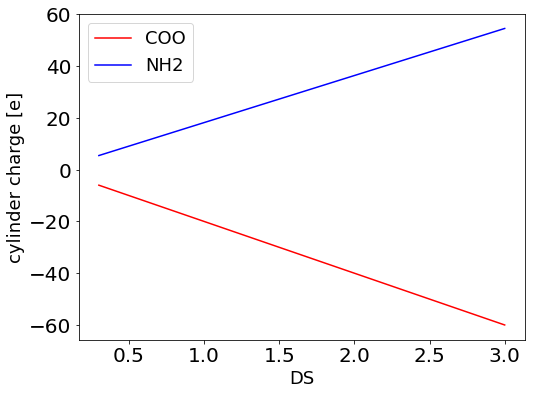

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
for func in func_charges.keys():
    ax.plot(DS, func_total_charges[func], label=func, c=func_colors[func])

ax.set_xlabel("DS", fontsize=18)
ax.set_ylabel("cylinder charge [e]", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=18)
plt.show()

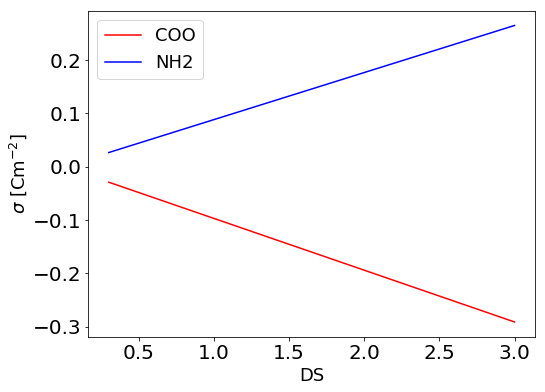

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
for func in func_charges.keys():
    ax.plot(DS, calculate_sigma_of_cylinder(func_total_charges[func], N*Lc, a), label=func, c=func_colors[func])

ax.set_xlabel("DS", fontsize=18)
ax.set_ylabel('$\sigma$ [Cm$^{-2}$]', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=18)
plt.show()

In [21]:
# calculate bjerrum length
# in angstrom
print("-------------------------------")
lb = calculate_bjerrum_length(Z1)
print('lb =', lb, 'angstrom')
lb_m = lb * (10 ** -10)
print('lb =', lb_m, 'm')
print("-------------------------------")
# calculate ionic strength
I = 0.5 * ((salt1_conc * Z1 * Z1) + (salt2_conc * Z2 * Z2))  # mol/L
print('I =', I, 'mol/L')
# in molec per m3
I_m = NA * I * 1000  # molecules / m3
print('I =', I_m, 'm^-3')
print("-------------------------------")
# calculate kappasq
# in angstrom^-2
kappasq = calculate_kappasq(lb_m, I_m)
print('kappa^2 =', kappasq, 'm^-2')
print('kappa =', np.sqrt(kappasq * (10 ** -20)), 'angstrom^-1')
print('debye length =', 1/np.sqrt(kappasq * (10 ** -20)), 'angstrom')
print("-------------------------------")
# reduced coordinates (unitless)
kr_ = np.sqrt(kappasq * (10 ** -20)) * r_

-------------------------------
lb = 28.587994507059786 angstrom
lb = 2.8587994507059787e-09 m
-------------------------------
I = 0.12 mol/L
I = 7.2265690284e+25 m^-3
-------------------------------
kappa^2 = 5.192251316240971e+18 m^-2
kappa = 0.22786512054812097 angstrom^-1
debye length = 4.3885610820758245 angstrom
-------------------------------


=================== COO ==================
negatively charged cylinder
=================== NH2 ==================
positively charged cylinder


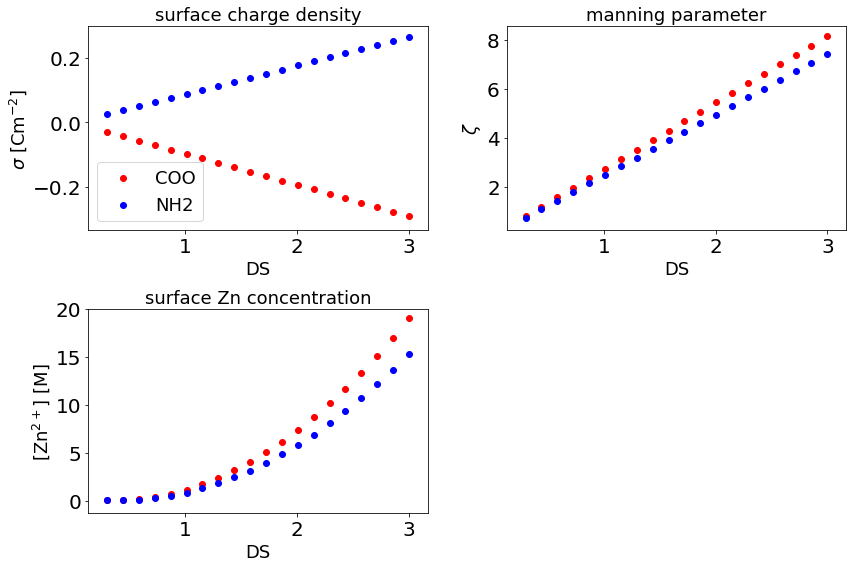

In [23]:
# iterate over funcationalities
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot(221)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2 = plt.subplot(222)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax3 = plt.subplot(223)
ax3.tick_params(axis='both', which='major', labelsize=20)

func_surface_concentration = {}
for func in func_charges.keys():
    print("==========================================")
    print("===================", func, "==================")
    # calculate surface charge density
    sigma = calculate_sigma_of_cylinder(func_total_charges[func], N*Lc, a)
    ax1.scatter(DS, sigma, c=func_colors[func], label=func)
    ax1.set_title('surface charge density', fontsize=18)
    ax1.set_xlabel("DS", fontsize=18)
    ax1.set_ylabel('$\sigma$ [Cm$^{-2}$]', fontsize=18)
    ax1.legend(fontsize=18)
    # Equation 1.4
    # line charge density lambda
    lamb = calculate_lambda(a, sigma)
    # change defintiion of co and counter ions based on cylidner charge
    # ion valencies
    Z1 = 2  # zinc 2+
    Z2 = -1  # co-ion
    if lamb[-1] > 0:
        print("positively charged cylinder")
    elif lamb[-1] <= 0:
        print("negatively charged cylinder")
    #    Z1 = -1 * Z1
    #    Z2 = -1 * Z2
    # Equation 1.5
    zeta_ = calculate_manning_parameter(lamb, lb, Z1)
    ax2.scatter(DS, zeta_, c=func_colors[func], label=func)
    ax2.set_title('manning parameter', fontsize=18)
    ax2.set_xlabel("DS", fontsize=18)
    ax2.set_ylabel('$\zeta$', fontsize=18)
    
    # Equation 1.6
    n_plus_surface = calculate_zinc_surface_conc(zeta_, lb, a)
    
    #for i, ds in enumerate(DS):
    #    ax3.plot(r_, psi_[i], c=colour[i], label='DS = '+str(DS[i]))
    ax3.scatter(DS, n_plus_surface, c=func_colors[func], label=func)
    ax3.set_title('surface Zn concentration', fontsize=18)
    ax3.set_xlabel("DS", fontsize=18)
    ax3.set_ylabel("[Zn$^{2+}$] [M]", fontsize=18)
    
    func_surface_concentration[func] = n_plus_surface

    
    
    print("==========================================")
fig.tight_layout()
#fig.savefig('surface_conc_vs_DS.pdf', dpi=720, bbox_inches='tight')